In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

## Creation of the matrix (just load, last line)

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')

In [43]:
history_small = pd.read_csv('data/order_products__prior.csv', sep=',')

In [4]:
#orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history.head(5000000)

In [5]:
consumptions = pd.merge(history_small, orders, on="order_id")[['user_id','product_id']]

In [6]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

,user_id,product_id,aisle_id,department_id
0,202279,33120,86,16
1,153404,33120,86,16
2,23750,33120,86,16
3,58707,33120,86,16
4,166654,33120,86,16


In [7]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

The greatest user id is 206208.


In [8]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

In [9]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

The greatest aisle id is 134.


In [10]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

product_id
user_id aisle_id            
1       21                 2
        23                 2
        24                 4
        77                 2
        88                 1

In [11]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [12]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

23.5% processed
47.1% processed
70.6% processed
94.1% processed
Done !
23.7% processed
47.4% processed
71.1% processed
94.9% processed
Done !


In [16]:
# Load the user matrix
f=open("user_matrix.pk","rb")
user_matrix = pickle.load(f)
f.close()


206209

## Determine the optimal k

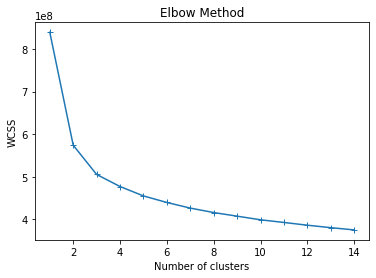

In [3]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss,marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method : the optimal number is k=3

Verification with silhouette methode :

In [13]:
#NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s1 = silhouette_score(user_matrix, labels)
#s1

0.6710904937285531

In [14]:
# NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s2 = silhouette_score(user_matrix, labels)
#s2

0.5245359402930275

Silhouette method actually gives 2

## Cluster sizes

In [18]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 2)

19429.0
186779.0


In [8]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 3)

167141.0
32179.0
6888.0


Clusters are very inequal, this clustering is not relevant.

## Clustering avec contrainte sur clusters size

In [65]:
import constrained_kmeans as cons

In [ ]:
#ne pas run : tres tres long
(C,M,f) = cons.constrained_kmeans(user_matrix, [92794,92794], maxiter=50)

Way too long to run (more than 6hours), never finished

## Dimensionnality reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [20]:
user_matrix = np.array(user_matrix)

In [21]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [22]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
reduc_matrix = pca.transform(user_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

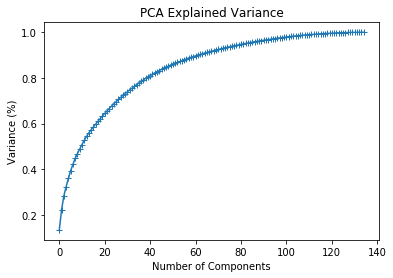

In [53]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=30

In [24]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [25]:
reduc_matrix.shape

(206209, 30)

Determine the right number of clusters (k)

In [ ]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 5 with this method

In [26]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [70]:
get_cluster_size(kmeans, 5, reduc_matrix)

38233.0
55661.0
7932.0
5366.0
99016.0


That's better : 3 pretty big clusters and 2 small (2 et 3)

## Analyse the clusters

**Look at centroids distance**

In [27]:
kmeans.cluster_centers_

array([[ 2.20106855e-01, -2.05952174e-01, -7.58680656e-03,
        -3.33052003e-02, -9.70075279e-03,  6.49935419e-03,
        -3.56051958e-03, -9.23150916e-04, -7.88428603e-03,
        -4.12997388e-03, -2.68752836e-03, -1.69194517e-04,
        -2.19231454e-03, -1.14639334e-03, -2.51229885e-03,
        -3.37561414e-03, -1.96986409e-03,  1.53978028e-04,
        -3.22464078e-04, -6.44794723e-04, -3.27162878e-03,
         9.16905126e-05, -5.17065595e-04, -1.73111708e-03,
        -2.48306175e-04, -1.05421802e-03, -1.72135550e-04,
        -9.85374955e-04, -4.81820310e-04, -1.20247067e-03],
       [-1.05700542e-01, -3.94683210e-04, -2.15981659e-02,
        -2.14269082e-02, -1.37612152e-02, -1.59922704e-03,
        -6.20522603e-03, -1.23552489e-03, -6.43928675e-03,
        -3.13087011e-03, -2.00628802e-03,  1.50453747e-03,
        -2.84338712e-03, -2.09911708e-04, -1.02851300e-03,
        -2.61719517e-03, -2.22267950e-03, -1.00477641e-04,
         8.99859653e-05, -2.34958942e-04, -1.16827566e-

In [29]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [30]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.38580685, 0.        , 0.        , 0.        , 0.        ],
       [0.28055434, 0.157692  , 0.        , 0.        , 0.        ],
       [0.61677855, 0.51200915, 0.51487239, 0.        , 0.        ],
       [0.35856946, 0.3041038 , 0.22265987, 0.58301387, 0.        ]])

cluster 2 and 3 are pretty 'basic' : look to all others, and are alike. Probably has something to do with the fact they are the two small clusters.

**prepare df**

In [18]:
aisles = pd.read_csv('data/aisles.csv', sep=',')

In [32]:
#convert the matrix into df
matrix_df = pd.DataFrame(user_matrix, index = range(len(user_matrix)), columns = ['Null']+list(aisles.aisle) )
matrix_df = matrix_df.drop('Null', axis=1) #drop first useless column
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [34]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = ['Null']+list(aisles.aisle) )
norm_matrix_df = norm_matrix_df.drop('Null', axis=1) #drop first useless column
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [35]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1


**Study the mean distribution of products per ailse in each clusters**

In [36]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002123,0.001514,0.008224,0.002355,0.000656,0.000887,0.000850,0.001216,0.002961,0.000244,...,0.001500,0.000268,0.000508,0.002618,0.002503,0.003035,0.003068,0.000067,0.000649,0.000230
1,0.001473,0.001123,0.006850,0.003790,0.001128,0.001029,0.000595,0.001203,0.002831,0.000343,...,0.001488,0.000922,0.002047,0.002446,0.003736,0.002258,0.003156,0.000229,0.001022,0.001012
2,0.002567,0.002671,0.014287,0.005979,0.001731,0.001005,0.000952,0.001151,0.006754,0.000256,...,0.001039,0.000509,0.000989,0.005913,0.005745,0.005061,0.008060,0.000159,0.000546,0.000261
3,0.001059,0.001020,0.010170,0.001512,0.000279,0.001192,0.000331,0.001106,0.000723,0.000448,...,0.002252,0.000595,0.001607,0.000786,0.000900,0.002188,0.001250,0.000163,0.001158,0.000434
4,0.001465,0.002725,0.006088,0.003394,0.001975,0.000786,0.001316,0.000778,0.006377,0.000280,...,0.000257,0.000285,0.000373,0.005164,0.003275,0.003623,0.007906,0.000109,0.000263,0.000159


**Evaluate the features discrimining the clusters**

In [37]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

packaged produce             -0.032598
body lotions soap            -0.024428
beers coolers                -0.022606
spirits                      -0.020095
soft drinks                  -0.019210
                                ...   
canned jarred vegetables      0.189171
packaged vegetables fruits    0.256488
fresh herbs                   0.275704
fresh vegetables              0.492389
cluster                       1.000000
Name: cluster, Length: 135, dtype: float64

features influencing the most the cluster affiliation seem to be the 9 ones listed above 
_not convinced by the method_

In [38]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [39]:
scores = SelectKBest(chi2, k=20).fit(X, Y)

In [40]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(10)

,Score
water seltzer sparkling water,36442.667916
fresh vegetables,25396.067433
fresh fruits,23157.141226
packaged vegetables fruits,4853.020135
yogurt,4845.900108
packaged produce,1810.679864
fresh herbs,1526.840554
milk,1397.062021
packaged cheese,1253.694844
soft drinks,703.056979


_better method_ most important features

In [41]:
imp_features = features.head(10).index

In [42]:
mean_clusters[imp_features]

,water seltzer sparkling water,fresh vegetables,fresh fruits,packaged vegetables fruits,yogurt,packaged produce,fresh herbs,milk,packaged cheese,soft drinks
cluster,,,,,,,,,,
0,0.020429,0.049471,0.379838,0.060263,0.025895,0.051307,0.006143,0.028160,0.016463,0.008375
1,0.010637,0.006015,0.004804,0.005294,0.004606,0.008994,0.001730,0.009283,0.009996,0.016490
2,0.024605,0.065293,0.107735,0.067970,0.064636,0.011968,0.008403,0.036615,0.035531,0.009066
3,0.520689,0.011110,0.029364,0.013760,0.015201,0.014236,0.001660,0.016135,0.009044,0.045107
4,0.016590,0.280475,0.110820,0.064215,0.025029,0.007595,0.023781,0.019579,0.023388,0.004329


0 : bcp de fresh fruits ; peu de soft drinks

1 : tres peu de packaged ; bcp de fresh vegetables  ; peu de soft drinks ; bcp herbs

2 : bcp de packaged ; peu d'herbs ; peu ice cream

3 :  bcp de sparkling water ; peu de fresh fruits ; peu de pack veg fruits ; bcp paper

4 : tres peu de packaged ; peu de fresh fruits ; peu de pack veg fruits ; bcp frozen meals ; bcp paper ; plus ice cream

classification healthiness : 1>0 (bons)  >  (mauvais) 3>2>4

## Client fidelity and ranking of products

In [3]:
import pickle
f=open("history_small","rb")
history_small = pickle.load(f)
f.close()

In [4]:
consumptions = pd.merge(history_small, orders, on="order_id")
consumptions["product_id_bis"]=consumptions["product_id"]

In [5]:
consumptions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id_bis
0,2,33120,1,1,202279,prior,3,5,9,8.0,33120
1,2,28985,2,1,202279,prior,3,5,9,8.0,28985
2,2,9327,3,0,202279,prior,3,5,9,8.0,9327
3,2,45918,4,1,202279,prior,3,5,9,8.0,45918
4,2,30035,5,0,202279,prior,3,5,9,8.0,30035


#### Fidelity = number of times each user re-bought each product

In [6]:
def get_fidelity(consumptions) :
    return consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum","product_id_bis" :"mean"})

def get_user_fidelity(fidelity) :
    fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'}).rename(columns={"reordered": "user_fidelity"})
    return fidelity_per_user

def product_addictivity(fidelity):
    return fidelity.groupby("product_id").agg({'reordered':'mean'}).rename(columns={"reordered": "satisfaction_per_product"})

In [7]:
fidelity = get_fidelity(consumptions)

#### Fidelity_per_user = number of times each user re-bought a product, on average

In [8]:
fidelity_per_user = get_user_fidelity(fidelity)
fidelity_per_user.sort_values("user_fidelity").tail()

,user_fidelity
user_id,
5588,11.088889
17997,11.250000
99753,12.500000
122725,12.750000
33799,13.000000


#### product_addictivity = number of times each product is re-bought by users, on average

In [9]:
product_addictivity = product_addictivity(fidelity)

In [10]:
product_addictivity.sort_values("satisfaction_per_product").tail()

,satisfaction_per_product
product_id,
25593,5.500000
21482,6.000000
12995,6.666667
12981,7.000000
19675,8.000000


#### Product_quality = how users like the product (weighted average over user fidelity)

In [11]:
def get_addictivities(fidelity):
    fidelity_per_user = get_user_fidelity(fidelity)
    # Get fidelity table together with average user fidelity
    with_user_fidelity = pd.merge(fidelity, fidelity_per_user[fidelity_per_user.user_fidelity>0], on="user_id")
    # Normalize fidelity to one product by user fidelity
    with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity
    per_product_add = with_user_fidelity.groupby("product_id_bis").agg({"appreciation_per_user":"mean"})
    return per_product_add

per_product_add = get_addictivities(fidelity)
per_product_add.sort_values("appreciation_per_user").head()

,appreciation_per_user
product_id_bis,
9211,0.0
7322,0.0
26024,0.0
37248,0.0
37243,0.0


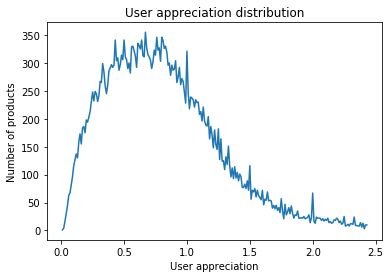

In [12]:
def plot(per_product_add, decimals=2):
    per_product_add["count"]=1
    per_product_add["appreciation_per_user"]=round(per_product_add["appreciation_per_user"],decimals)
    distribution_qualities = per_product_add.groupby("appreciation_per_user").agg({"count":"sum"})
    Y = list(distribution_qualities.values)
    X = list(distribution_qualities.index)
    l = round(len(Y)/2)
    plt.plot(X[1:l],Y[1:l])
    plt.xlabel("User appreciation")
    plt.ylabel("Number of products")
    plt.title("User appreciation distribution")
    
plot(per_product_add)

Left-skewed distribution, with average 1 by definition (we normalized by user enthousiasm).

#### Now let's try to get a "satisfaction score" for each aisle

We might think about averaging the scores, but some of them may be undefined, and some products might be much more consumed than others.

In [13]:
# Weight given to each product = number of times it was bought
consumptions["count_consumptions"] = 1
product_weights = consumptions.groupby("product_id").agg({"count_consumptions":"sum"})

In [14]:
# Columns of qualities_and_weights : product_id || score of the product || number of times it was bought
quality_per_product["product_id"] = quality_per_product.index
qualities_and_weights = pd.merge(product_weights, quality_per_product, on="product_id")

# qualities_joined links the previous dataset with data about products (aisle, department...)
qualities_joined = pd.merge(qualities_and_weights, products, on="product_id")
qualities_joined["sum_appreciations"]=qualities_joined.appreciation_per_user * qualities_joined.count_consumptions

NameError: name 'quality_per_product' is not defined

In [ ]:
qualities_joined.head()

In [ ]:
# Quality of an aisle = weighted average of scores of its products

# Group by aisle remembering sum of scores and total weight
aisle_avg_quality = qualities_joined.groupby("aisle_id").agg({"count_consumptions":"sum","sum_appreciations":"sum"})

# Make a smart division to obtain weighted average
aisle_avg_quality["aisle_score"] = aisle_avg_quality.sum_appreciations / aisle_avg_quality.count_consumptions

# Put the name of the aisle with previous data
aisle_avg_quality = pd.merge(aisle_avg_quality[["aisle_score","count_consumptions"]], aisles, on="aisle_id")

The score is difficult to interpret. Nevertheless, a score bigger than 1 means that the majority of products bought in the aisle are more often re-consumed than the overall average. The smaller the score, the less often consumers tend to re-buy the products of the aisle.

The column "count_consumptions" may be considered as the reilabilit of the score. The smaller, the less orders were made from this aisle, the more an outlier consumer can biase the score.

In [ ]:
# Aisles that contain most "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").tail(10)

In [ ]:
# Aisles that contain least "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").head(20)

### Get scores per cluster

Approach of cluster fidelity appreciation by products in the aisles

In [62]:
array_clusters = np.array(mean_clusters)
columns = list(mean_clusters.columns)
aisle_scores =np.array(aisle_avg_quality[["aisle_score","aisle"]])

In [67]:
aisle_names = list(mean_clusters.columns)

def aisle_name_to_id(aisle_name):
    for k in range(len(aisles)):
        if aisles.values[k][1]==aisle_name :
            return k+1
    return 1/0

def id_to_aisle_name(aisle_id):
    return aisles.values[aisle_id-1][1]

def sort_scores(scores, aisle_names):
    s = np.zeros(len(scores))
    for k in range(0, len(scores)):
        score, aisle_name = scores[k][0], scores[k][1]
        aisle_id = aisle_name_to_id(aisle_name)
        s[aisle_id-1] = score
    return s

sc =sort_scores(aisle_scores, aisle_names)

In [66]:
# Here is the average naive "fidelity appealing" of each cluster, that depends on the products in the aisles 
# and the weights of each aisle for clusters
array_clusters.dot(sc)

array([1.53181251, 0.45394151, 1.25503206, 1.63255259, 1.20895988])

Approach of cluster fidelity by simple fidelity of the customers

In [104]:
# The weight of each user is its number of consumptions
user_weight = consumptions[["user_id","order_id","count_consumptions"]]
user_weight = user_weight.groupby("user_id").agg({"count_consumptions":"sum"})
user_weight_fidelity = pd.merge(user_weight, fidelity_per_user, on = "user_id")
user_weight_fidelity["cluster"]=kmeans.labels_
user_weight_fidelity.head(10)

,count_consumptions,user_fidelity,cluster
user_id,,,
1,59,2.277778,1
2,195,0.911765,0
3,88,1.666667,1
4,18,0.058824,2
5,37,0.608696,1
6,14,0.166667,2
7,206,2.029412,2
8,49,0.361111,2
9,76,0.310345,1


In [105]:
user_weight_fidelity["sum_fidelity"]=user_weight_fidelity.count_consumptions * user_weight_fidelity.user_fidelity
cluster_fidelity = user_weight_fidelity.groupby("cluster").agg({"count_consumptions":"sum","sum_fidelity":"sum"})
cluster_fidelity["average_fidelity"] = cluster_fidelity.sum_fidelity / cluster_fidelity.count_consumptions
cluster_fidelity

,count_consumptions,sum_fidelity,average_fidelity
cluster,,,
0,2193110,4.748108e+06,2.165011
1,14162024,2.999993e+07,2.118336
2,10542295,2.241777e+07,2.126460
3,596776,1.314166e+06,2.202110
4,4940284,1.048428e+07,2.122203


Sadness, disappointment, nothing interesting here :(

In [28]:
consumptions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id_bis
0,2,33120,1,1,202279,prior,3,5,9,8.0,33120
1,2,28985,2,1,202279,prior,3,5,9,8.0,28985
2,2,9327,3,0,202279,prior,3,5,9,8.0,9327
3,2,45918,4,1,202279,prior,3,5,9,8.0,45918
4,2,30035,5,0,202279,prior,3,5,9,8.0,30035


In [31]:
def get_features_users(consumptions) :
    '''Returns a dataframes with all features concerning users we might dream about'''
    
    user_features = get_user_fidelity(get_fidelity(consumptions))

    return user_features


user_features = get_features_users(consumptions)
user_features.head(10)

,user_fidelity
user_id,
1,0.888889
3,0.666667
4,0.000000
5,0.666667
6,0.285714
7,0.971429
9,0.000000
10,0.227273
12,0.227273


In [42]:
def get_nb_items(consumptions) :
    a = consumptions.groupby(["user_id","order_id"]).agg({"add_to_cart_order":"max"})
    return a.groupby("user_id").agg({"add_to_cart_order":"mean"}).rename({"add_to_cart_order":"nb_items"})

nb_items = get_nb_items(consumptions)

In [54]:
def get_temporal_info(consumptions) :
    a = consumptions[consumptions.add_to_cart_order==1]
    return a.groupby("user_id").agg({"order_hour_of_day":"mean","days_since_prior_order":"mean"})

temporal_info =  get_temporal_info(consumptions)

In [17]:
nb_consumptions  = consumptions.groupby("user_id").agg({"count_consumptions":"sum"})
nb_consumptions.head()

,count_consumptions
user_id,
1,13
3,14
4,2
5,12
6,7


In [ ]:
consumptions_with_aisles = pd.merge(consumptions, products, on="product_id")

In [46]:
consumption_per_aisle = consumptions_with_aisles.groupby(["user_id","aisle_id"]).agg({"count_consumptions":"sum"})

In [47]:
consumption_per_aisle.head()

count_consumptions
user_id aisle_id                    
1       21                         2
        23                         2
        24                         4
        77                         2
        88                         1

In [48]:
c = consumption_per_aisle.pivot_table(index ="user_id", columns='aisle_id', fill_value=0)['count_consumptions']
c.head()

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
print(aisles.values)

[[1 'prepared soups salads']
 [2 'specialty cheeses']
 [3 'energy granola bars']
 [4 'instant foods']
 [5 'marinades meat preparation']
 [6 'other']
 [7 'packaged meat']
 [8 'bakery desserts']
 [9 'pasta sauce']
 [10 'kitchen supplies']
 [11 'cold flu allergy']
 [12 'fresh pasta']
 [13 'prepared meals']
 [14 'tofu meat alternatives']
 [15 'packaged seafood']
 [16 'fresh herbs']
 [17 'baking ingredients']
 [18 'bulk dried fruits vegetables']
 [19 'oils vinegars']
 [20 'oral hygiene']
 [21 'packaged cheese']
 [22 'hair care']
 [23 'popcorn jerky']
 [24 'fresh fruits']
 [25 'soap']
 [26 'coffee']
 [27 'beers coolers']
 [28 'red wines']
 [29 'honeys syrups nectars']
 [30 'latino foods']
 [31 'refrigerated']
 [32 'packaged produce']
 [33 'kosher foods']
 [34 'frozen meat seafood']
 [35 'poultry counter']
 [36 'butter']
 [37 'ice cream ice']
 [38 'frozen meals']
 [39 'seafood counter']
 [40 'dog food care']
 [41 'cat food care']
 [42 'frozen vegan vegetarian']
 [43 'buns rolls']
 [44 'eye ea

In [52]:
not_value_aisle_indexes = [11, 20, 22, 25, 40, 41, 44, 54, 55, 56, 60, 73, 74, 75, 80, 82, 85, 87, 101, 102, 109, 114, 118, 126, 127, 132, 6, 47, 88, 92, 100, 133]